# tensorflow HOG

The histogram of oriented gradients (HOG) implemented in tensorflow. Based on the codes from [digamma-ai's tfcv](https://github.com/digamma-ai/tfcv), where I made the following changes:

1. Fixing the bugs when running with newer version tensorflow (>=1.4).
2. Completing the orientation function.
3. Modifying the bin partition function to suit the orientation function.
4. Automatically pad the input images.
5. Masking the unwanted gradients of edge pixels.
6. Visualizing HOG image (use the codes from skimage v0.14).

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import data, color

from PIL import Image
%matplotlib inline

D:\Conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_sobel_kernel(ksize):
    if (ksize % 2 == 0) or (ksize < 1):
        raise ValueError("Kernel size must be a positive odd number")
    _base = np.arange(ksize) - ksize//2
    a = np.broadcast_to(_base, (ksize,ksize))
    b = ksize//2 - np.abs(a).T
    s = np.sign(a)
    return a + s*b


def get_gaussian_kernel(ksize = 3, sigma = -1.0):
    ksigma = 0.15*ksize + 0.35 if sigma <= 0 else sigma
    i, j   = np.mgrid[0:ksize,0:ksize] - (ksize-1)//2
    kernel = np.exp(-(i**2 + j**2) / (2*ksigma**2))
    return kernel / kernel.sum()


def get_laplacian_of_gaussian_kernel(ksize = 3, sigma = -1.0):
    ksigma = 0.15*ksize + 0.35 if sigma <= 0 else sigma
    i, j   = np.mgrid[0:ksize,0:ksize] - (ksize-1)//2
    kernel = (i**2 + j**2 - 2*ksigma**2) / (ksigma**4) * np.exp(-(i**2 + j**2) / (2*ksigma**2))
    return kernel - kernel.mean()


def tf_kernel_prep_4d(kernel, n_channels):
    return np.tile(kernel, (n_channels, 1, 1, 1)).swapaxes(0,2).swapaxes(1,3)


def tf_kernel_prep_3d(kernel, n_channels):
    return np.tile(kernel, (n_channels, 1, 1)).swapaxes(0,1).swapaxes(1,2)


def tf_filter2d(batch, kernel, strides=(1,1), padding='SAME'):
    n_ch = batch.shape[3].value
    tf_kernel = tf.constant(tf_kernel_prep_4d(kernel, n_ch))
    return tf.nn.depthwise_conv2d(batch, tf_kernel, [1, strides[0], strides[1], 1], padding=padding)

 
def tf_deriv(batch, ksize=3, padding='SAME'):
    try:
        n_ch = batch.shape[3].value
    except:
        n_ch = int(batch.get_shape()[3])
    gx = tf_kernel_prep_3d(np.array([[ 0, 0, 0],
                                     [-1, 0, 1],
                                     [ 0, 0, 0]]), n_ch)    
    gy = tf_kernel_prep_3d(np.array([[ 0, -1, 0],
                                     [ 0, 0, 0],
                                     [ 0, 1, 0]]), n_ch)   
    kernel = tf.constant(np.stack([gx, gy], axis=-1), name="DerivKernel", dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding, name="GradXY")
    

def tf_sobel(batch, ksize=3, padding='SAME'):
    n_ch = batch.shape[3].value
    gx = tf_kernel_prep_3d(get_sobel_kernel(ksize),   n_ch)
    gy = tf_kernel_prep_3d(get_sobel_kernel(ksize).T, n_ch)
    kernel = tf.constant(np.stack([gx, gy], axis=-1), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)


def tf_sharr(batch, ksize=3, padding='SAME'):
    n_ch = batch.shape[3].value
    gx = tf_kernel_prep_3d([[ -3, 0,  3],
                            [-10, 0, 10],
                            [ -3, 0,  3]], n_ch)    
    gy = tf_kernel_prep_3d([[-3,-10,-3],
                            [ 0,  0, 0],
                            [ 3, 10, 3]], n_ch)    
    kernel = tf.constant(np.stack([gx, gy], axis=-1), dtype = np.float32)
    return tf.nn.depthwise_conv2d(batch, kernel, [1, 1, 1, 1], padding=padding)


def tf_laplacian(batch, padding='SAME'):
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]], dtype=batch.dtype)    
    return tf_filter2d(batch, kernel, padding=padding)


def tf_boxfilter(batch, ksize = 3, padding='SAME'):
    kernel = np.ones((ksize, ksize), dtype=batch.dtype) / ksize**2
    return tf_filter2d(batch, kernel, padding=padding)

def tf_rad2deg(rad):
    return 180 * rad / tf.constant(np.pi)

In [3]:
def tf_select_by_idx(a, idx, grayscale):
    if grayscale:
        return a[:,:,:,0]
    else:
        return tf.where(tf.equal(idx, 2), 
                         a[:,:,:,2], 
                         tf.where(tf.equal(idx, 1), 
                                   a[:,:,:,1], 
                                   a[:,:,:,0]))
    

def tf_hog_descriptor(images, cell_size = 8, block_size = 2, block_stride = 1, n_bins = 9,
                      grayscale = False):

    batch_size, height, width, depth = images.shape
    scale_factor = tf.constant(180 / n_bins, name="scale_factor", dtype=tf.float32)
    
    img = tf.constant(images, name="ImgBatch", dtype=tf.float32)

    if grayscale:
        img = tf.image.rgb_to_grayscale(img, name="ImgGray")

    # automatically padding height and width to valid size (multiples of cell size)
    if height % cell_size != 0 or width % cell_size != 0:
        height = height + (cell_size - (height % cell_size)) % cell_size
        width = width + (cell_size - (width % cell_size)) % cell_size
        img = tf.image.resize_image_with_crop_or_pad(img, height, width)
    
    # gradients
    grad = tf_deriv(img)
    g_x = grad[:,:,:,0::2]
    g_y = grad[:,:,:,1::2]
    
    # masking unwanted gradients of edge pixels
    mask_depth = 1 if grayscale else depth
    g_x_mask = np.ones((batch_size, height, width, mask_depth))
    g_y_mask = np.ones((batch_size, height, width, mask_depth))
    g_x_mask[:, :, (0, -1)] = 0
    g_y_mask[:, (0, -1)] = 0
    g_x_mask = tf.constant(g_x_mask, dtype=tf.float32)
    g_y_mask = tf.constant(g_y_mask, dtype=tf.float32)
    
    g_x = g_x*g_x_mask
    g_y = g_y*g_y_mask

    # maximum norm gradient selection
    g_norm = tf.sqrt(tf.square(g_x) + tf.square(g_y), "GradNorm")
    
    if not grayscale and depth != 1:
        # maximum norm gradient selection
        idx    = tf.argmax(g_norm, 3)
        g_norm = tf.expand_dims(tf_select_by_idx(g_norm, idx, grayscale), -1)
        g_x    = tf.expand_dims(tf_select_by_idx(g_x,    idx, grayscale), -1)
        g_y    = tf.expand_dims(tf_select_by_idx(g_y,    idx, grayscale), -1)

    g_dir = tf_rad2deg(tf.atan2(g_y, g_x)) % 180
    g_bin = tf.to_int32(g_dir / scale_factor, name="Bins")

    # cells partitioning
    cell_norm = tf.space_to_depth(g_norm, cell_size, name="GradCells")
    cell_bins = tf.space_to_depth(g_bin,  cell_size, name="BinsCells")

    # cells histograms
    hist = list()
    zero = tf.zeros(cell_bins.get_shape()) 
    for i in range(n_bins):
        mask = tf.equal(cell_bins, tf.constant(i, name="%i"%i))
        hist.append(tf.reduce_mean(tf.where(mask, cell_norm, zero), 3))
    hist = tf.transpose(tf.stack(hist), [1,2,3,0], name="Hist")

    # blocks partitioning
    block_hist = tf.extract_image_patches(hist, 
                                          ksizes  = [1, block_size, block_size, 1], 
                                          strides = [1, block_stride, block_stride, 1], 
                                          rates   = [1, 1, 1, 1], 
                                          padding = 'VALID',
                                          name    = "BlockHist")

    # block normalization
    block_hist = tf.nn.l2_normalize(block_hist, 3, epsilon=1.0)
    
    # HOG descriptor
    hog_descriptor = tf.reshape(block_hist, 
                                [int(block_hist.get_shape()[0]), 
                                 int(block_hist.get_shape()[1]) * \
                                 int(block_hist.get_shape()[2]) * \
                                 int(block_hist.get_shape()[3])], 
                                 name='HOGDescriptor')

    return hog_descriptor, block_hist, hist

In [4]:
tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X = data.astronaut().reshape([-1,512,512,3])/255
    hog_descriptor, block_hist, hist = tf_hog_descriptor(X, grayscale = True)
    hog = hog_descriptor.eval()
    bh = block_hist.eval()
    h = hist.eval()

In [5]:
hog

array([[0.03819511, 0.01498414, 0.        , ..., 0.01729969, 0.02597499,
        0.00844154]], dtype=float32)

## Drawing HOG image

The code is borrowed from visualize part of [scikit-image](https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_hog.py)

In [6]:
from skimage import draw

def hog_image(img, hist, cell_size=8, orientations=9):
    c_row, c_col = (cell_size, cell_size)
    s_row, s_col = img.shape[:2]

    n_cells_row = int(s_row // c_row)  # number of cells along row-axis
    n_cells_col = int(s_col // c_col)  # number of cells along col-axis

    radius = min(c_row, c_col) // 2 - 1
    orientations_arr = np.arange(orientations)
    # set dr_arr, dc_arr to correspond to midpoints of orientation bins
    orientation_bin_midpoints = (
        np.pi * (orientations_arr + .5) / orientations)
    dr_arr = radius * np.sin(orientation_bin_midpoints)
    dc_arr = radius * np.cos(orientation_bin_midpoints)
    hog_image = np.zeros((s_row, s_col), dtype=float)
    for r in range(n_cells_row):
        for c in range(n_cells_col):
            for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                centre = tuple([r * c_row + c_row // 2,
                                c * c_col + c_col // 2])
                rr, cc = draw.line(int(centre[0] - dc),
                                   int(centre[1] + dr),
                                   int(centre[0] + dc),
                                   int(centre[1] - dr))
                hog_image[rr, cc] += hist[r, c, o]

    return hog_image

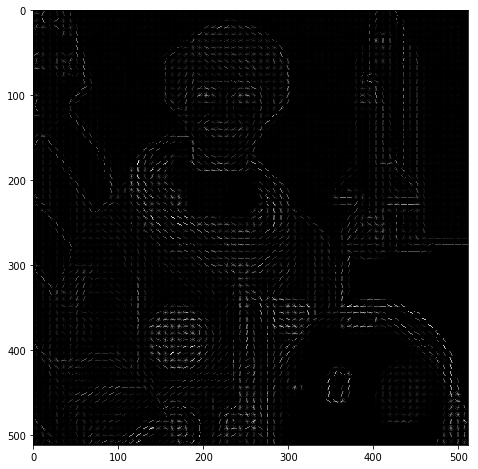

In [7]:
tf_hog_image = hog_image(data.astronaut(), h[0])
plt.figure(figsize=(8,8))
plt.imshow(tf_hog_image, cmap=plt.cm.gray)
plt.show()

## Compare the result with skimage

Due to the result of skimage version 0.14(dev) is different from version 0.13.1(stable), I borrowed the HOG codes from their github [scikit-image(_hog.py)](https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_hog.py) and [scikit-image(hoghistogram.pyx)](https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/_hoghistogram.pyx), or you can install their [development version](http://scikit-image.org/docs/dev/install.html#development-installation) directly.

In [8]:
def _hog_channel_gradient(channel):
    """Compute unnormalized gradient image along `row` and `col` axes.
    Parameters
    ----------
    channel : (M, N) ndarray
        Grayscale image or one of image channel.
    Returns
    -------
    g_row, g_col : channel gradient along `row` and `col` axes correspondingly.
    """
    g_row = np.empty(channel.shape, dtype=np.double)
    g_row[0, :] = 0
    g_row[-1, :] = 0
    g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]
    g_col = np.empty(channel.shape, dtype=np.double)
    g_col[:, 0] = 0
    g_col[:, -1] = 0
    g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

    return g_row, g_col

In [9]:
image = color.rgb2gray(data.astronaut())
image = np.atleast_2d(image)
g_row, g_col = _hog_channel_gradient(image)
magnitude = np.hypot(g_col, g_row)
orientation = np.rad2deg(np.arctan2(g_row, g_col)) % 180

In [10]:
def cell_hog(magnitude, orientation, 
             orientation_start, orientation_end,
             cell_columns, cell_rows,
             column_index, row_index,
             size_columns, size_rows,
             range_rows_start, range_rows_stop,
             range_columns_start, range_columns_stop):
    
    total = 0.

    for cell_row in range(range_rows_start, range_rows_stop):
        cell_row_index = row_index + cell_row
        if (cell_row_index < 0 or cell_row_index >= size_rows):
            continue

        for cell_column in range(range_columns_start, range_columns_stop):
            cell_column_index = column_index + cell_column
            if (cell_column_index < 0 or cell_column_index >= size_columns
                    or orientation[cell_row_index, cell_column_index]
                    >= orientation_start
                    or orientation[cell_row_index, cell_column_index]
                    < orientation_end):
                continue

            total += magnitude[cell_row_index, cell_column_index]

    return total / (cell_rows * cell_columns)

In [11]:
orientations = 9
c_row, c_col = (8, 8)
s_row, s_col = image.shape[:2]

n_cells_row = int(s_row // c_row)  # number of cells along row-axis
n_cells_col = int(s_col // c_col)  # number of cells along col-axis

orientation_histogram = np.zeros((n_cells_row, n_cells_col, orientations))

cell_rows = 8
cell_columns = 8
number_of_cells_rows = 64
number_of_cells_columns = 64
number_of_orientations = 9
size_columns = 512
size_rows = 512


r_0 = cell_rows // 2
c_0 = cell_columns // 2
cc = cell_rows * number_of_cells_rows
cr = cell_columns * number_of_cells_columns
range_rows_stop = cell_rows // 2
range_rows_start = -range_rows_stop
range_columns_stop = cell_columns // 2
range_columns_start = -range_columns_stop
number_of_orientations_per_180 = 180. / number_of_orientations


# compute orientations integral images
for i in range(number_of_orientations):
    # isolate orientations in this range
    orientation_start = number_of_orientations_per_180 * (i + 1)
    orientation_end = number_of_orientations_per_180 * i
    c = c_0
    r = r_0
    r_i = 0
    c_i = 0

    while r < cc:
        c_i = 0
        c = c_0

        while c < cr:
            orientation_histogram[r_i, c_i, i] = \
                cell_hog(magnitude, orientation,
                         orientation_start, orientation_end,
                         cell_columns, cell_rows, c, r,
                         size_columns, size_rows,
                         range_rows_start, range_rows_stop,
                         range_columns_start, range_columns_stop)
            c_i += 1
            c += cell_columns

        r_i += 1
        r += cell_rows

In [12]:
tf_hog_image = hog_image(data.astronaut(), h[0])
ski_hog_image = hog_image(data.astronaut(), orientation_histogram)

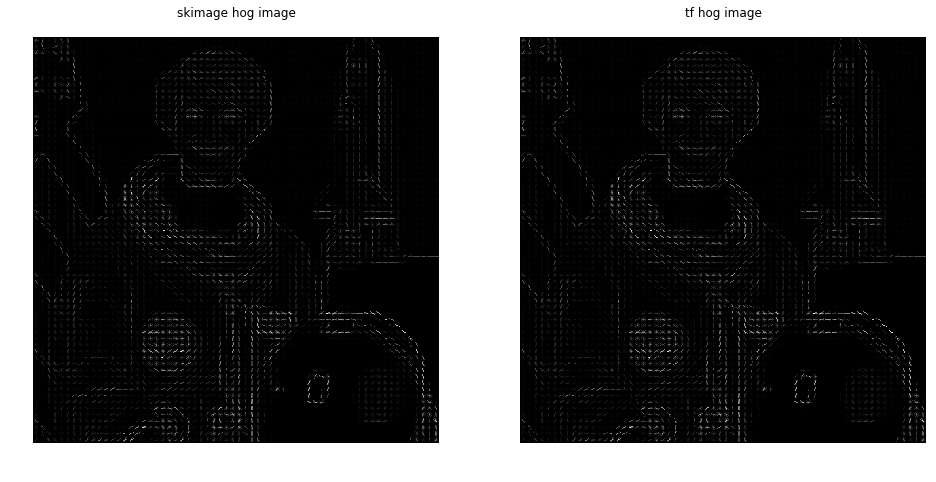

In [13]:
from skimage import exposure

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ski_hog_image_rescaled = exposure.rescale_intensity(ski_hog_image, in_range=(0, 10))
tf_hog_image_rescaled = exposure.rescale_intensity(tf_hog_image, in_range=(0, 10))

ax1.axis('off')
ax1.imshow(ski_hog_image_rescaled, cmap=plt.cm.gray)
ax1.set_title('skimage hog image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(tf_hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('tf hog image')
ax1.set_adjustable('box-forced')
plt.show()